<a href="https://colab.research.google.com/github/Khadijaissoufou/NLP-Job-Market-Analysis/blob/main/Projet_analyse_textuelle_2025_2026.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**PROJET TEXTOMETRIE**

In [2]:
from google.colab import files

# Choisir le fichier depuis le pc
uploaded = files.upload()


Saving Emploidata.txt to Emploidata (1).txt


INFO:stanza:Downloaded file to /root/stanza_resources/resources.json
INFO:stanza:Downloading default packages for language: fr (French) ...
INFO:stanza:File exists: /root/stanza_resources/fr/default.zip
INFO:stanza:Finished downloading models and saved to /root/stanza_resources
INFO:stanza:Checking for updates to resources.json in case models have been updated.  Note: this behavior can be turned off with download_method=None or download_method=DownloadMethod.REUSE_RESOURCES


INFO:stanza:Downloaded file to /root/stanza_resources/resources.json
INFO:stanza:Loading these models for language: fr (French):
| Processor | Package           |
---------------------------------
| tokenize  | combined          |
| mwt       | combined          |
| pos       | combined_charlm   |
| lemma     | combined_nocharlm |

INFO:stanza:Using device: cpu
INFO:stanza:Loading: tokenize
INFO:stanza:Loading: mwt
INFO:stanza:Loading: pos
INFO:stanza:Loading: lemma
INFO:stanza:Done loading processors!


Nombre d'offres valides : 100
Top 20 VERBES : [('participer', 105), ('développer', 102), ('travailler', 98), ('contribuer', 78), ('accompagner', 77), ('permettre', 77), ('proposer', 61), ('engager', 59), ('rechercher', 58), ('intégrer', 58), ('créer', 57), ('offrir', 50), ('suivre', 49), ('améliorer', 47), ('analyser', 45), ('assurer', 45), ('réaliser', 42), ('aider', 40), ('souhaiter', 38), ('comprendre', 37)]
Top 20 ADJECTIFS : [('technique', 88), ('commercial', 86), ('international', 74), ('financier', 62), ('interne', 56), ('professionnel', 54), ('innovant', 51), ('opérationnel', 46), ('différent', 45), ('dynamique', 44), ('stratégique', 44), ('digital', 42), ('durable', 39), ('mondial', 35), ('social', 30), ('futur', 28), ('analytique', 27), ('meilleur', 26), ('technologique', 24), ('français', 23)]
Top 20 NOMS : [('équipe', 313), ('donnée', 309), ('analyse', 212), ('projet', 180), ('client', 173), ('outil', 168), ('compétence', 132), ('groupe', 118), ('environnement', 118), ('emp

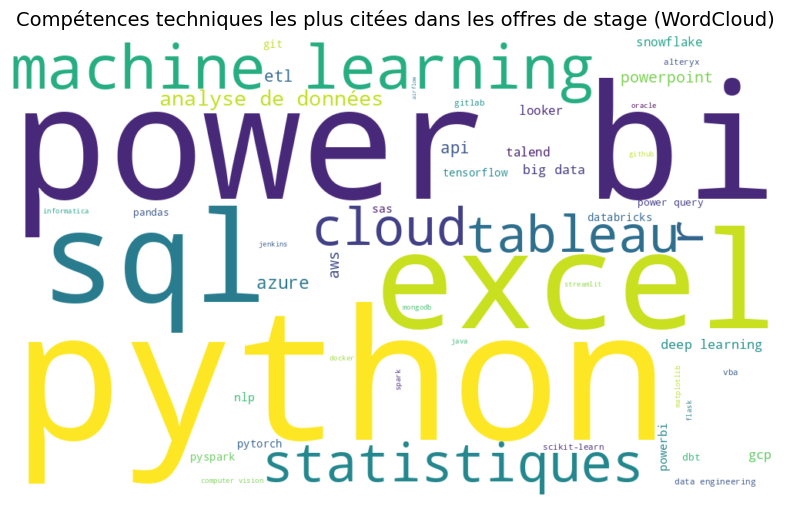


Top 15 compétences citées :
            Compétence  Occurrences
48              python           62
43            power bi           59
17               excel           55
57                 sql           50
32    machine learning           32
58        statistiques           30
7                cloud           28
60             tableau           27
51                   r           24
2   analyse de données           22
5                azure           15
16                 etl           12
3                  api           12
46          powerpoint           11
4                  aws           11


In [3]:
# @title


!pip install stanza -q
import re
import stanza  # tout en minuscules
import matplotlib.pyplot as plt
import seaborn as sns



# 1. Initialisation de Stanza
stanza.download('fr')  # à faire une seule fois
nlp = stanza.Pipeline(lang='fr', processors='tokenize,mwt,pos,lemma', tokenize_pretokenized=False)

# 2. Lecture du fichier
with open("Emploidata.txt", "r", encoding="utf-8") as f:
    texte_brut = f.read()

# 3. Nettoyage basique
texte_nettoye = re.sub(r"[,:;'\"()\n]+", " ", texte_brut)  # suppression ponctuation et retours à la ligne
# Nettoyage du séparateur ****
texte_nettoye = re.sub(r"\s*\*{4,}\s*", "****", texte_nettoye)

# 4. Découpage en offres
offres = [o.strip() for o in texte_nettoye.split("****") if len(o.strip()) > 50]  # filtre les blocs trop courts
print(f"Nombre d'offres valides : {len(offres)}")

# 6. EXTRACTION TITRE / CORPS
idtex = []         # Liste des titres (1er mot de chaque offre)
texte_corps = []   # Liste du corps de l'offre (tout sauf le titre)

for offre in offres:
    mots = offre.split()
    titre = mots[0]                # Premier mot = titre
    corps = " ".join(mots[1:])    # Reste = corps
    idtex.append(titre)
    texte_corps.append(corps)

# 7. PASSAGE DANS STANZA ET EXTRACTION DES INFORMATIONS
# ON TRAITE TOUTES LES OFFRES
all_mots = []
all_lemmes = []
all_pos = []
all_feats = []
all_caract = []

for offre in texte_corps:
    doc = nlp(offre)
    for sentence in doc.sentences:
        for word in sentence.words:
            all_mots.append(word.text)                 # mot original
            all_lemmes.append(word.lemma)              # lemme
            all_pos.append(word.upos)                  # catégorie grammaticale
            all_feats.append(word.feats)               # traits grammaticaux
            all_caract.append([word.text, word.lemma, word.upos, word.feats])  # tableau complet


# 8/IMPORTS
import pandas as pd
from collections import Counter
import re

# CHARGER LA LISTE DE STOPWORDS DEPUIS GITHUB
url = 'https://raw.githubusercontent.com/gillesbastin/french_stopwords/main/french_stopwords.csv'
stopwords_df = pd.read_csv(url, sep=';')
stop_words_liste = stopwords_df["token"].tolist()

# LISTES DE MOTS À EXCLURE
auxiliaires = {'être', 'avoir', 'faire', 'pouvoir', 'devoir', 'aller', 'vouloir', 'hésiter', 'venir', 'partir', 'rejoindre'}
noms_generiques = {'entreprise', 'action', 'propos', 'offre', 'mission', 'stage'}
adjs_generiques = {'nouveau', 'grand', 'principal', 'possible', 'divers', 'fort'}

# FILTRAGE ET NORMALISATION
caract_b_rsw = []
for (mot, lemme, pos, feats) in all_caract:
    lemme_lower = lemme.lower()
    # On retire stopwords et chiffres
    if lemme_lower not in stop_words_liste and not re.search(r'\d', lemme_lower):
        caract_b_rsw.append((mot.lower(), lemme_lower, pos))  # tout en minuscules

# EXTRACTION PAR CATÉGORIE AVEC FILTRAGE
verbs = [lemme for (mot, lemme, pos) in caract_b_rsw if pos == 'VERB' and lemme not in auxiliaires]
adjs  = [lemme for (mot, lemme, pos) in caract_b_rsw if pos == 'ADJ' and lemme not in adjs_generiques]
nouns = [lemme for (mot, lemme, pos) in caract_b_rsw if pos == 'NOUN' and lemme not in noms_generiques]

# TOP MOTS
top_verbs = Counter(verbs).most_common(20)
top_adjs  = Counter(adjs).most_common(20)
top_nouns = Counter(nouns).most_common(20)

print("Top 20 VERBES :", top_verbs)
print("Top 20 ADJECTIFS :", top_adjs)
print("Top 20 NOMS :", top_nouns)

# 9/ LISTE HARD SKILLS
import re
from wordcloud import WordCloud
import matplotlib.pyplot as plt
import pandas as pd

# --- Liste initiale et additionnelle de hard skills ---
hard_skills = ["Python", "R", "SQL", "NoSQL", "MongoDB", "PostgreSQL", "MySQL", "Oracle",
               "Excel", "VBA", "Tableau", "PowerBI", "QlikView", "Looker", "Google Data Studio",
               "SAS", "SPSS", "Hadoop", "Spark", "PySpark", "TensorFlow", "Keras", "Scikit-learn",
               "PyTorch", "Numpy", "Pandas", "Matplotlib", "Seaborn", "Plotly", "Dash", "D3.js",
               "API", "Cloud", "Git", "GitHub", "GitLab", "Docker", "Kubernetes", "Airflow",
               "Jenkins", "ETL", "Talend", "Informatica", "Data Warehousing", "Data Modeling",
               "BigQuery", "Redshift", "Snowflake", "Azure", "AWS", "GCP", "Machine Learning",
               "Deep Learning", "NLP", "Computer Vision", "Streamlit", "Power Query", "Power Pivot",
               "Tableau Prep", "dbt", "Jupyter", "Colab", "RStudio", "KNIME", "Alteryx", "Excel Modeling",
               "HBase", "Cassandra", "Kafka", "Flink", "NiFi", "ElasticSearch", "Databricks", "Hive",
               "Pig", "Spark SQL", "Spark Streaming", "MLlib", "OpenCV", "NLTK", "spaCy", "Gensim",
               "FastAPI", "Flask", "Django", "Neo4j", "Redis", "RabbitMQ", "Airbyte", "Prefect", "Luigi"]

nouveaux_terms = [
    "python", "sql", "excel", "power bi", "tableau", "sas", "r", "java", "spark",
    "hadoop", "airflow", "git", "linux", "machine learning", "deep learning",
    "data visualization", "etl", "cloud", "azure", "aws", "gcp", "nosql",
    "pandas", "numpy", "scikit-learn", "tensorflow", "pytorch", "kafka", "powerpoint",
    "analyse de données", "statistiques", "data engineering", "big data"
]

# --- Fusion et nettoyage (tout en minuscules + suppression des doublons) ---
hard_skills_fusion = sorted(set([h.lower() for h in hard_skills] + [n.lower() for n in nouveaux_terms]))
print(f"Nombre total de hard skills fusionnées : {len(hard_skills_fusion)}\n")

# --- Lecture et nettoyage du texte ---
with open("Emploidata.txt", "r", encoding="utf-8") as f:
    texte = f.read().lower()

# --- Comptage des occurrences exactes ---
competences_trouvees = []
for comp in hard_skills_fusion:
    occur = len(re.findall(rf"\b{re.escape(comp)}\b", texte))
    if occur > 0:
        competences_trouvees.append((comp, occur))

# --- Préparer le dictionnaire pour le WordCloud ---
competences_dict = dict(competences_trouvees)

# 10--- Génération du nuage ---
plt.figure(figsize=(10,6))
wordcloud = WordCloud(width=1000, height=600, background_color="white",
                      colormap="viridis", max_words=50).generate_from_frequencies(competences_dict)
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.title("Compétences techniques les plus citées dans les offres de stage (WordCloud)", fontsize=14)
plt.show()

# --- Affichage top 15 compétences ---
df_comp = pd.DataFrame(competences_trouvees, columns=["Compétence", "Occurrences"]).sort_values(by="Occurrences", ascending=False)
print("\nTop 15 compétences citées :")
print(df_comp.head(15))





DESCRIPTION DE LA BDD

In [ ]:
# @title
import pandas as pd
import matplotlib.pyplot as plt

# EXTRAIRE LES VALEURS DIRECTEMENT DES OBJETS
nb_offres = len(texte_corps)
nb_mots_total = len(caract_b_rsw)
nb_lemmes_uniques = pd.DataFrame(caract_b_rsw, columns=["mot","lemme","pos"])['lemme'].nunique()

# Répartition POS
df_mots = pd.DataFrame(caract_b_rsw, columns=["mot","lemme","pos"])
pos_counts = df_mots['pos'].value_counts()

# Limiter aux stats PEMIERES
stats = {
    'Nombre d’offres': nb_offres,
    'Nombre total de mots': nb_mots_total,
    'Nombre de lemmes uniques': nb_lemmes_uniques,
    'Nombre de NOUN': pos_counts.get('NOUN', 0),
    'Nombre de VERB': pos_counts.get('VERB', 0),
    'Nombre de ADJ': pos_counts.get('ADJ', 0),
    'Nombre de PROPN': pos_counts.get('PROPN', 0),
    'Nombre de PUNCT': pos_counts.get('PUNCT', 0),
    'Nombre de X': pos_counts.get('X', 0)
}

# Créer DataFrame
df_table = pd.DataFrame(list(stats.items()), columns=['Statistiques', 'Valeur'])

# --- Générer image du tableau ---
fig, ax = plt.subplots(figsize=(8, 4))
ax.axis('tight')
ax.axis('off')
table = ax.table(cellText=df_table.values,
                 colLabels=df_table.columns,
                 cellLoc='center',
                 colColours=['#1f77b4', '#1f77b4'],
                 colWidths=[0.6, 0.3],
                 loc='center')
table.auto_set_font_size(False)
table.set_fontsize(12)
table.scale(1, 2)
table_props = table.properties()['children']

# Colorer les cellules (bleu clair pour le corps)
for cell in table_props[1:]:
    cell.set_facecolor('#e6f2ff')

plt.title("Résumé des statistiques textuelles des offres", fontsize=14, color='#1f77b4', pad=20)
plt.tight_layout()
plt.show()





TOP 5 VERBES NOMS  & ADJECTIFS

In [ ]:
# @title
import matplotlib.pyplot as plt
import pandas as pd

# On prend le top 5 de chaque catégorie
top_verbs_5 = top_verbs[:5]
top_adjs_5  = top_adjs[:5]
top_nouns_5 = top_nouns[:5]

# Créer les DataFrames avec catégorie
df_verbs = pd.DataFrame(top_verbs_5, columns=['Mot', 'Occurrences'])
df_verbs['Catégorie'] = 'Verbe'

df_adjs = pd.DataFrame(top_adjs_5, columns=['Mot', 'Occurrences'])
df_adjs['Catégorie'] = 'Adjectif'

df_nouns = pd.DataFrame(top_nouns_5, columns=['Mot', 'Occurrences'])
df_nouns['Catégorie'] = 'Nom'

# Fusionner les trois DataFrames
df_top5 = pd.concat([df_verbs, df_adjs, df_nouns], ignore_index=True)
df_top5 = df_top5[['Mot', 'Catégorie', 'Occurrences']]

# Création de la figure pour le tableau
fig, ax = plt.subplots(figsize=(8,6))
ax.axis('off')  # on cache les axes

# Ajouter le tableau
tbl = ax.table(cellText=df_top5.values,
               colLabels=df_top5.columns,
               cellLoc='center',
               loc='center')

tbl.auto_set_font_size(False)
tbl.set_fontsize(12)
tbl.scale(1, 2)  # ajuste la hauteur des lignes

# Sauvegarde en image
plt.savefig("tableau_top5.png", bbox_inches='tight', dpi=300)
plt.show()


GRAPHIQUE PAR CATEGORIE DE HARDSKILLS ET PYTHON MODULES

In [ ]:
# @title

# 9/ LISTE HARD SKILLS
import re
from wordcloud import WordCloud
import matplotlib.pyplot as plt
import pandas as pd

# --- Liste initiale et additionnelle de hard skills ---
hard_skills = ["Python", "R", "SQL", "NoSQL", "MongoDB", "PostgreSQL", "MySQL", "Oracle",
               "Excel", "VBA", "Tableau", "PowerBI", "QlikView", "Looker", "Google Data Studio",
               "SAS", "SPSS", "Hadoop", "Spark", "PySpark", "TensorFlow", "Keras", "Scikit-learn",
               "PyTorch", "Numpy", "Pandas", "Matplotlib", "Seaborn", "Plotly", "Dash", "D3.js",
               "API", "Cloud", "Git", "GitHub", "GitLab", "Docker", "Kubernetes", "Airflow",
               "Jenkins", "ETL", "Talend", "Informatica", "Data Warehousing", "Data Modeling",
               "BigQuery", "Redshift", "Snowflake", "Azure", "AWS", "GCP", "Machine Learning",
               "Deep Learning", "NLP", "Computer Vision", "Streamlit", "Power Query", "Power Pivot",
               "Tableau Prep", "dbt", "Jupyter", "Colab", "RStudio", "KNIME", "Alteryx", "Excel Modeling",
               "HBase", "Cassandra", "Kafka", "Flink", "NiFi", "ElasticSearch", "Databricks", "Hive",
               "Pig", "Spark SQL", "Spark Streaming", "MLlib", "OpenCV", "NLTK", "spaCy", "Gensim",
               "FastAPI", "Flask", "Django", "Neo4j", "Redis", "RabbitMQ", "Airbyte", "Prefect", "Luigi"]

nouveaux_terms = [
    "python", "sql", "excel", "power bi", "tableau", "sas", "r", "java", "spark",
    "hadoop", "airflow", "git", "linux", "machine learning", "deep learning",
    "data visualization", "etl", "cloud", "azure", "aws", "gcp", "nosql",
    "pandas", "numpy", "scikit-learn", "tensorflow", "pytorch", "kafka", "powerpoint",
    "analyse de données", "statistiques", "data engineering", "big data"
]

# --- Fusion et nettoyage (tout en minuscules + suppression des doublons) ---
hard_skills_fusion = sorted(set([h.lower() for h in hard_skills] + [n.lower() for n in nouveaux_terms]))
print(f"Nombre total de hard skills fusionnées : {len(hard_skills_fusion)}\n")

# --- Lecture et nettoyage du texte ---
with open("Emploidata.txt", "r", encoding="utf-8") as f:
    texte = f.read().lower()

# --- Comptage des occurrences exactes ---
competences_trouvees = []
for comp in hard_skills_fusion:
    occur = len(re.findall(rf"\b{re.escape(comp)}\b", texte))
    if occur > 0:
        competences_trouvees.append((comp, occur))

# --- Préparer le dictionnaire pour le WordCloud ---
competences_dict = dict(competences_trouvees)

# 10--- Génération du nuage ---
plt.figure(figsize=(10,6))
wordcloud = WordCloud(width=1000, height=600, background_color="white",
                      colormap="viridis", max_words=50).generate_from_frequencies(competences_dict)
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.title("Compétences techniques les plus citées dans les offres de stage (WordCloud)", fontsize=14)
plt.show()

# --- Affichage top 15 compétences ---
df_comp = pd.DataFrame(competences_trouvees, columns=["Compétence", "Occurrences"]).sort_values(by="Occurrences", ascending=False)
print("\nTop 15 compétences citées :")
print(df_comp.head(15))





N GRAMMES

In [ ]:
# @title
import pandas as pd
import matplotlib.pyplot as plt
from collections import Counter
from nltk import bigrams, trigrams

# --- Mots à exclure ---
exclus = {
    'fin','étude','poste','description','offre','propos',
    'principal','mission','profil','compétence','étudiant'
}
exclus_tri = exclus.union({'contrat','stage','type'})

# --- Nettoyage des lemmes ---
lemmes_clean = [
    lemme for (mot, lemme, pos) in caract_b_rsw
    if lemme.isalpha() and lemme not in exclus
]

# --- Bigrammes filtrés ---
bi = [
    b for b in bigrams(lemmes_clean)
    if b not in [("mise","place"), ("mise","œuvre"), ("mise","oeuvre")]
]
top_bi = Counter(bi).most_common(10)

# --- Trigrammes filtrés ---
tri = [
    t for t in trigrams(lemmes_clean)
    if not any(w in exclus_tri for w in t)
    and ("mise","place") not in (t[:2], t[1:])
    and ("mise","œuvre") not in (t[:2], t[1:])
]
top_tri = Counter(tri).most_common(10)

# --- DataFrames pour affichage texte ---
df_bigrams = pd.DataFrame(top_bi, columns=['Bigramme', 'Occurrences'])
df_bigrams['Bigramme'] = df_bigrams['Bigramme'].apply(lambda x: ' '.join(x))

df_trigrams = pd.DataFrame(top_tri, columns=['Trigramme', 'Occurrences'])
df_trigrams['Trigramme'] = df_trigrams['Trigramme'].apply(lambda x: ' '.join(x))

print("Top 10 Bigrammes :")
print(df_bigrams)

print("\nTop 10 Trigrammes :")
print(df_trigrams)

# --- Visualisation ---
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# Bigrammes
axes[0].barh(df_bigrams['Bigramme'], df_bigrams['Occurrences'], color='steelblue')
axes[0].set_title("Top 10 Bigrammes")
axes[0].set_xlabel("Fréquence")
axes[0].invert_yaxis()

# Trigrammes
axes[1].barh(df_trigrams['Trigramme'], df_trigrams['Occurrences'], color='darkorange')
axes[1].set_title("Top 10 Trigrammes")
axes[1].set_xlabel("Fréquence")
axes[1].invert_yaxis()

plt.tight_layout()
plt.show()


soft skills


In [ ]:
# @title
import re
import pandas as pd
import matplotlib.pyplot as plt
from wordcloud import WordCloud

# Méga-liste de soft skills
soft_skills = [
    "rigoureux", "rigoureuse", "autonome", "curieux", "curieuse", "réactif", "réactive",
    "organisé", "organisée", "méthodique", "créatif", "créative", "esprit d'équipe",
    "communication", "collaboratif", "collaborative", "flexible", "proactif", "proactive",
    "analytique", "responsable", "motivé", "motivée", "adaptable", "persévérant",
    "persévérante", "esprit critique", "sociable", "dynamique", "autodidacte",
    "curiosité intellectuelle", "initiative", "esprit d'analyse", "esprit de synthèse",
    "sens de l'organisation", "gestion du temps", "capacité à travailler sous pression",
    "capacité d'adaptation", "rigueur", "collaboration", "coopératif", "coopérative",
    "esprit d'initiative", "leadership", "capacité à résoudre des problèmes", "créativité",
    "sens de l'écoute", "esprit logique", "capacité à prioriser", "polyvalent", "polyvalente",
    "motivation", "engagement", "curiosité", "persistance", "autonomie", "organisation",
    "capacité d'apprentissage rapide", "qualité relationnelle", "sens de la communication",
    "orientation résultats", "capacité d'analyse", "travail en équipe", "gestion des conflits",
    "esprit stratégique", "capacité à travailler en autonomie", "capacité à synthétiser",
    "capacité de décision", "force de proposition", "esprit positif", "relationnel"
]

# Lecture du texte
with open("Emploidata.txt", "r", encoding="utf-8") as f:
    texte = f.read().lower()

# Comptage des occurrences
competences_soft = []
for skill in soft_skills:
    occur = len(re.findall(rf"\b{re.escape(skill.lower())}\b", texte))
    if occur > 0:
        competences_soft.append((skill, occur))

# DataFrame trié par fréquence
df_soft = pd.DataFrame(competences_soft, columns=["Qualité", "Occurrences"]).sort_values(by="Occurrences", ascending=False)

# Top 5
top_soft = df_soft.head(5)
print("Top 5 Soft Skills / Qualités valorisées :")
print(top_soft)

# Dictionnaire pour WordCloud
soft_dict = dict(zip(df_soft['Qualité'], df_soft['Occurrences']))
wordcloud = WordCloud(width=600, height=400, background_color="white",
                      colormap="cool", max_words=50).generate_from_frequencies(soft_dict)

# Affichage combiné
fig, axs = plt.subplots(1, 2, figsize=(14,6))

# Graphique en barres
axs[0].barh(top_soft['Qualité'][::-1], top_soft['Occurrences'][::-1], color='skyblue')
axs[0].set_xlabel("Occurrences")
axs[0].set_title("Top 5 Soft Skills / Qualités valorisées")

# WordCloud
axs[1].imshow(wordcloud, interpolation="bilinear")
axs[1].axis("off")
axs[1].set_title("WordCloud - Soft Skills valorisées")

plt.tight_layout()
plt.show()


SECTEURS QUI RECRUTENT LE PLUS

In [ ]:
# @title
import re
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# --- Lecture du corpus ---
with open("Emploidata.txt", "r", encoding="utf-8") as f:
    texte = f.read()

# --- Découpage des offres
offres = [o.strip() for o in texte.split("****") if o.strip()]

# --- Dictionnaire de secteurs par mots-clés
secteurs_keywords = {
    r"\b(banque|finance|assurance|crédit)\b": "Banque & Assurance",
    r"\b(santé|pharma|médical|hôpital|clinique|mutuelle)\b": "Santé",
    r"\b(énergie|edf|total|engie|gaz|nucléaire)\b": "Énergie",
    r"\b(industrie|aéronautique|automobile|bâtiment|vinci|production)\b": "Industrie",
    r"\b(retail|commerce|distribution|grande surface|carrefour|auchan|decathlon|lagardère)\b": "Retail / Commerce",
    r"\b(conseil|consultant|cabinet|equancy|capgemini|ey|pwc|kpmg|deloitte)\b": "Conseil & Services",
    r"\b(technologie|informatique|digital|data|ia|intelligence artificielle|it|logiciel|start-up)\b": "Tech / Informatique",
    r"\b(enseignement|université|école|institut|éducation)\b": "Éducation",
    r"\b(public|ministère|administration|mairie|collectivité)\b": "Secteur public",
}

# --- Extraction des entreprises et secteurs
entreprises = []
secteurs = []

for offre in offres:
    lignes = [l.strip() for l in offre.splitlines() if l.strip()]
    entreprise = lignes[0] if lignes else "Inconnue"
    entreprises.append(entreprise)

    secteur_trouve = "Autre"
    for motif, secteur in secteurs_keywords.items():
        if re.search(motif, offre.lower()):
            secteur_trouve = secteur
            break
    secteurs.append(secteur_trouve)

# --- Création du DataFrame
df_secteurs = pd.DataFrame({"Entreprise": entreprises, "Secteur": secteurs})

# --- Comptage des occurrences
top_secteurs = df_secteurs["Secteur"].value_counts().head(10).reset_index()
top_secteurs.columns = ["Secteur", "Nombre d'offres"]

# --- Visualisation
sns.set(style="whitegrid", palette="Set2")
plt.figure(figsize=(9,6))
sns.barplot(data=top_secteurs, x="Nombre d'offres", y="Secteur")
plt.title("Top 10 secteurs les plus recruteurs dans les offres de stage", fontsize=14)
plt.xlabel("Nombre d'occurrences")
plt.ylabel("Secteur d'activité")
plt.tight_layout()
plt.show()

# --- Affichage texte
print("\nTop 10 secteurs les plus recruteurs :")
print(top_secteurs)


PROFILS LES PLUS RECHERCHES

In [ ]:
# @title
import re
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Initialisation des listes pour stocker les intitulés et les entreprises
intitules = []
entreprises = []

# Parcours de chaque offre pour extraire les informations utiles
for offre in offres:
    lignes = [l.strip() for l in offre.splitlines() if l.strip()]
    entreprise = lignes[0] if lignes else "Inconnue"
    entreprises.append(entreprise)

    # Recherche d'expressions liées aux métiers de la data
    match = re.search(
        r"(data\s+(analyst|scientist|engineer|consultant|manager|specialist))|"
        r"(business\s+analyst)|"
        r"(chef\s+de\s+projet\s+(data|digital|bi))|"
        r"(charg[eé]\s+d['e]\s+(études|analyse|statistiques?))|"
        r"(ingénieur\s+(data|ia|intelligence\s+artificielle|informatique))|"
        r"(consultant\s+(data|bi|digital|ia))|"
        r"(alternant|stagiaire|assistant)\s+(en\s+(data|analyse|bi|statistique|informatique))",
        offre.lower()
    )

    titre = match.group(0).strip().title() if match else "Autre"
    intitules.append(titre)

# Création du tableau avec les intitulés bruts
df_jobs = pd.DataFrame({"Entreprise": entreprises, "Intitulé brut": intitules})

# Fonction pour regrouper les intitulés similaires sous un même nom
def normaliser_titre(t):
    t = t.lower().strip()
    t = re.sub(r"h/f|alternance|stagiaire|stage|assistant|junior|senior", "", t)
    t = t.replace("  ", " ").strip()
    if "business analyst" in t:
        return "Business Analyst"
    elif "data analyst" in t:
        return "Data Analyst"
    elif "data scientist" in t:
        return "Data Scientist"
    elif "data engineer" in t:
        return "Data Engineer"
    elif "consultant" in t:
        return "Consultant Data/BI"
    elif "chef de projet" in t or "project manager" in t:
        return "Chef de projet Data/Digital"
    elif "charg" in t or "étude" in t or "statist" in t:
        return "Chargé d'études statistiques"
    elif "intelligence artificielle" in t or "ia" in t or "ml" in t:
        return "Ingénieur IA"
    elif "data manager" in t:
        return "Data Manager"
    elif "bi analyst" in t:
        return "BI Analyst"
    elif "data architect" in t:
        return "Data Architect"
    elif "data quality" in t or "qualité données" in t:
        return "Data Quality Analyst"
    else:
        return "Autre"

# Application de la normalisation
df_jobs["Intitulé normalisé"] = df_jobs["Intitulé brut"].apply(normaliser_titre)

# On garde uniquement les intitulés reconnus
df_jobs = df_jobs[df_jobs["Intitulé normalisé"] != "Autre"]

# Comptage des métiers les plus fréquents
top_jobs = df_jobs["Intitulé normalisé"].value_counts().head(10).reset_index()
top_jobs.columns = ["Métier", "Nombre d'offres"]

# Affichage du graphique
sns.set(style="whitegrid", palette="deep")
plt.figure(figsize=(9,6))
sns.barplot(data=top_jobs, x="Nombre d'offres", y="Métier")
plt.title("Top 10 métiers les plus demandés", fontsize=14)
plt.xlabel("Nombre d'occurrences")
plt.ylabel("Intitulé du poste")
plt.tight_layout()
plt.show()

# Impression du tableau
print(top_jobs)


CLUSTERING/KMEANS

In [ ]:
# @title
# Créer  une liste de “documents” où chaque document = une offre
documents = []

for offre in texte_corps:
    doc = nlp(offre)
    mots_filtrés = []
    for sentence in doc.sentences:
        for word in sentence.words:
            lemme = word.lemma.lower()
            pos = word.upos
            if (lemme not in stop_words_liste
                and not re.search(r'\d', lemme)
                and ((pos == 'NOUN' and lemme not in noms_generiques)
                     or (pos == 'VERB' and lemme not in auxiliaires)
                     or (pos == 'ADJ' and lemme not in adjs_generiques))):
                mots_filtrés.append(lemme)
    documents.append(" ".join(mots_filtrés))

print(f"Nombre de documents pour clustering : {len(documents)}")


Nombre de documents pour clustering : 100


In [ ]:
# @title
#TF-IDF Vectorization
from sklearn.feature_extraction.text import TfidfVectorizer

vectorizer = TfidfVectorizer()
X = vectorizer.fit_transform(documents)
terms = vectorizer.get_feature_names_out()


In [ ]:
# @title
from sklearn.cluster import KMeans
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# --- 1. Méthode du coude ---
K = range(1, 10)
inerties = []
for k in K:
    km = KMeans(n_clusters=k, random_state=42).fit(X)
    inerties.append(km.inertia_)

# --- 2. Clustering avec k=2 ---
k = 2
kmeans = KMeans(n_clusters=k, random_state=42)
kmeans.fit(X)
labels = kmeans.labels_

cluster_counts = pd.Series(labels).value_counts().sort_index()

# --- 3. Affichage : coude + répartition côte à côte ---
fig, axes = plt.subplots(1, 2, figsize=(12, 4))

# A gauche : inertie (méthode du coude)
axes[0].plot(K, inerties, marker='o', color='steelblue')
axes[0].set_title("Méthode du coude (Inertie)")
axes[0].set_xlabel("Nombre de clusters (k)")
axes[0].set_ylabel("Inertie")
axes[0].grid(True, linestyle="--", alpha=0.6)
axes[0].axvline(2, color='red', linestyle='--', label='k = 2')
axes[0].legend()

# A droite : répartition
axes[1].bar(cluster_counts.index, cluster_counts.values, color='skyblue')
axes[1].set_title(f"Répartition des {cluster_counts.sum()} offres (k=2)")
axes[1].set_xlabel("Cluster")
axes[1].set_ylabel("Nombre d'offres")
for i, v in enumerate(cluster_counts.values):
    axes[1].text(i, v + 1, str(v), ha='center', fontsize=11, fontweight='bold')
axes[1].grid(axis='y', linestyle="--", alpha=0.6)

plt.tight_layout()
plt.show()

# --- 4. Résumé numérique ---
print("Répartition des offres par cluster :")
print(cluster_counts)

# --- 5. Tableau lexical (mots caractéristiques de chaque cluster) ---
terms = vectorizer.get_feature_names_out()
cluster_lexical = {}

for i in range(k):
    indices = np.where(labels == i)[0]
    cluster_matrix = X[indices].mean(axis=0)
    top_indices = np.array(cluster_matrix).argsort()[0][-15:][::-1]
    cluster_lexical[f"Cluster {i}"] = [terms[j] for j in top_indices]

lexical_df = pd.DataFrame.from_dict(cluster_lexical, orient='index', columns=[f"Mot {i+1}" for i in range(15)])
print("Tableau lexical par cluster :")
print(lexical_df)


